Generates the neural distances between different phonemes, as in figure 1-supplementary figure 5 ("Neural activity shows phonetic structure") of Stavisky et al. eLife 2019.
The underlying data is in T5-phonemes_distances.npy .
Requires the following python libraries:
 - numpy, matplotlib, scipy
 
Note that some of the analyses take a while to run, and there are flags in the code that will run approximations faster. Comments will point these out.

Questions, comments, and concerns should be directed to Guy Wilson at ghwilson [at] stanford [dot] edu.
November 2019, Stanford University

In [4]:
import sys
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

sys.path.append('helper_functions/python_utils/firingrate/')
sys.path.append('helper_functions/python_utils/statistics/')
sys.path.append('helper_functions/python_utils/visualization/')


# load our data (averaged population FR vectors in a 150 msec window centered on each phoneme's onset):

phoneme_data   = np.load('./datasets/T5-phonemes_distances.npy', allow_pickle = True)
phonemes_id    = phoneme_data[0]   # hold phoneme type (e.g. /t/ or /g/)
phonemes_trl   = phoneme_data[1]   # hold the trial number in which the phoneme occurred 
phonemes_order = phoneme_data[2]   # hold relative ordering of phoneme within the trial (e.g. 1, 2, 3, etc.)
phonemes_FR    = phoneme_data[3]   # hold the FR vectors for each phoneme (in spikes/ms, hence multiply by 1000 later)


# now get a way to map out indices of a given phoneme type:
unique, inverse, counts = np.unique(phonemes_id, return_inverse= True, return_counts = True)
numunits                = phonemes_FR.shape[0]

The following code will calculate distances. Will take a while to run with biasCorrection = True. 

For a faster (approximate) version, set biasCorrection = False.

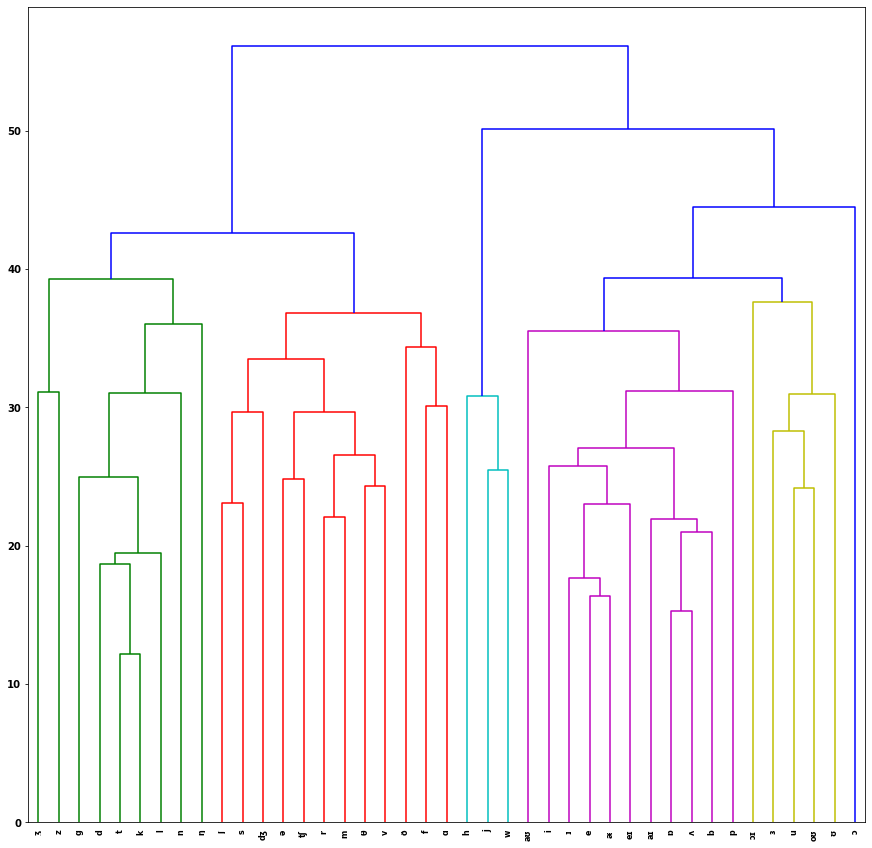

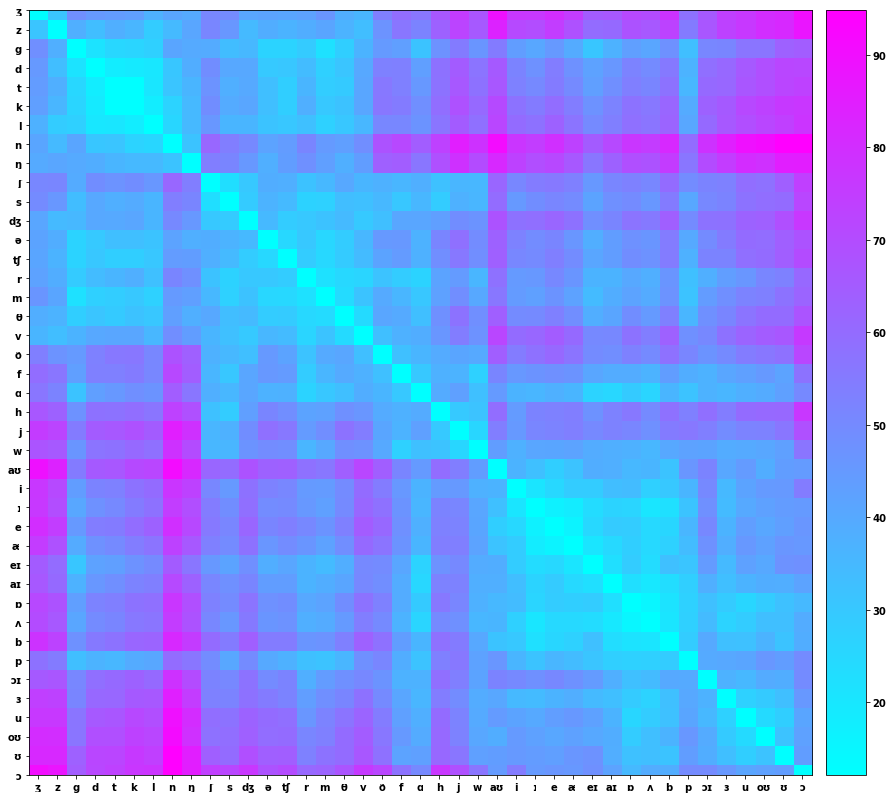

In [5]:
from matrixplots import plotDistanceMatrix

# make figure larger, bold text:
matplotlib.rcParams['figure.figsize'] = [15, 15]
matplotlib.rcParams.update({'font.weight': 'bold'})

# remove phonemes with a low trial count: 
highrep_set  = np.where(counts >= 10)[0]
highrep_trls = np.isin(inverse, highrep_set) 

# the following function will: 1) calculate adjusted distances 2) build a dendrogram from distances (upper diagonal) and 3) 

# NOTE: the adjusted distance calculation can (and often will!) return negative "distances" -this should be interpreted as your groups being very close and/or having really noisy data 
# for our dendrogram, we zero out the negatives. For reference, please see: https://github.com/fwillett/cvVectorStats or https://www.biorxiv.org/content/10.1101/659839v1 

plt.set_cmap('cool')
_, speech_ordered, ordering = plotDistanceMatrix(1000*phonemes_FR[:,highrep_trls], trl_labels = phonemes_id[highrep_trls], metric = 'euclidean', 
                                                 clustering_method = 'average', sorted = True, biasCorrection = True, save_dendrogram = True, clip_negatives = False)

The following data are returned:
    
    speech_ordered (np array) - the plotted distance matrix, sorted according to <ordering>
    ordering       (list)     - manner in which highrep_set is ordered (by index i.e. unique[highrep_set][ordering] will give the axis labels)

optional: do resampling of the on-diagonal to characterize noise

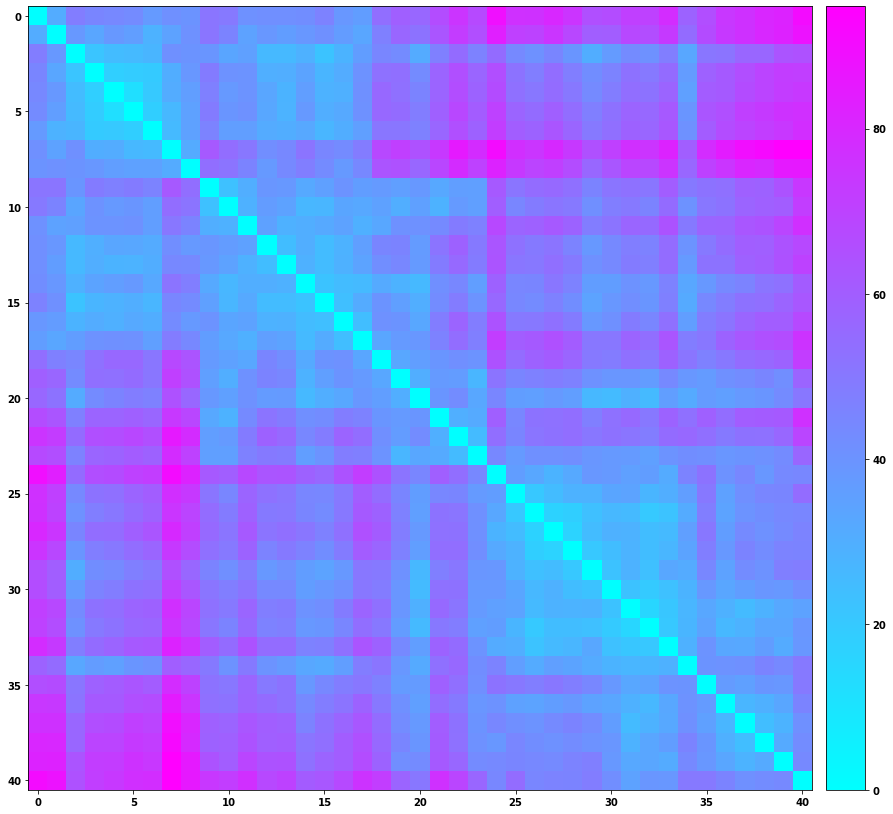

In [6]:
from subsample import unbiasedDistance
from mpl_toolkits.axes_grid1 import make_axes_locatable

num_iterations = 20

for i, ph in enumerate(unique[ordering]):
    within_dists = np.zeros((num_iterations))
    FR_vecs      = phonemes_FR[:, phonemes_id == ph]
    num_examples = np.arange(FR_vecs.shape[1])
    half         = int(np.round(len(num_examples) / 2))
    for j in range(num_iterations):
        np.random.shuffle(num_examples)
        grp1 = FR_vecs[:, num_examples[:half]]
        grp2 = FR_vecs[:, num_examples[half:]]
        
        within_dists[j], _, _ = unbiasedDistance(grp1, grp2, subtractMean=False, metric = 'euclidean')
    
    speech_ordered[i, i] = np.mean(within_dists)
        
        
        
fig     = plt.figure()
ax      = plt.gca()
im      = ax.imshow(speech_ordered)
divider = make_axes_locatable(ax)
cax     = divider.append_axes("right", size="5%", pad=0.2)
ax.figure.colorbar(im, cax=cax)

generate matrix sorted by place of articulation ordering:

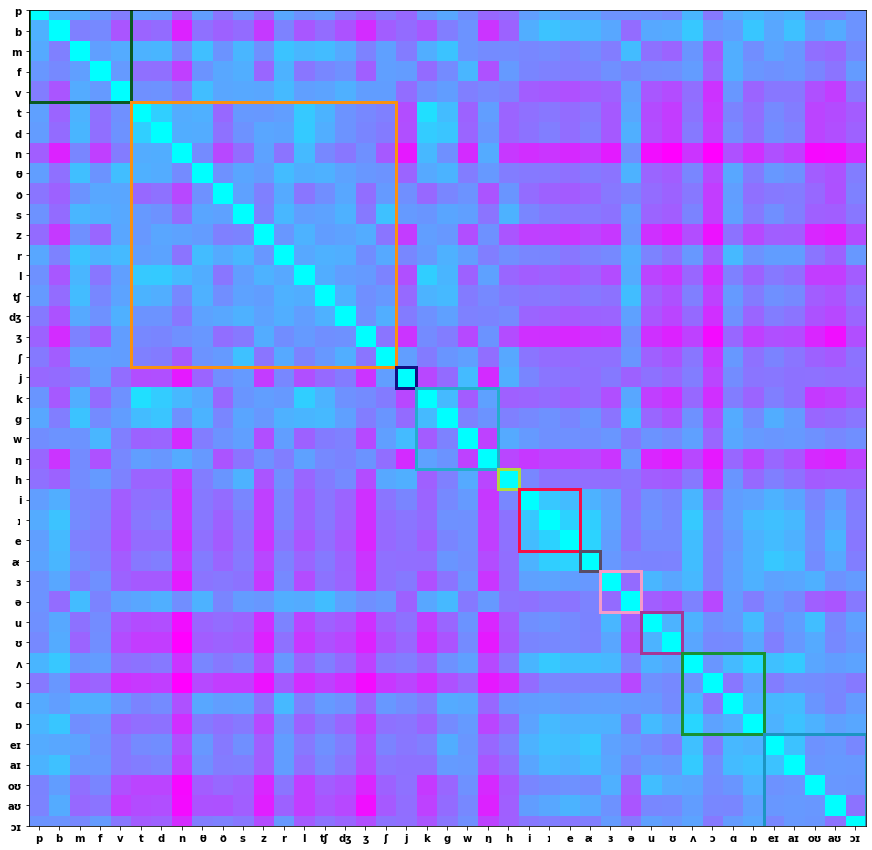

In [7]:
from matplotlib.patches import Rectangle 

matrix_ordering  = unique[highrep_set][ordering]   # subselect highrep phonemes we used, then permute accordingly to get the ordering from our plotting output
poa_ordering   = ['p', 'b', 'm', 'f', 'v', 't', 'd', 'n', 'θ', 'ð', 's', 'z', 'r', 'l', 'tʃ', 'dʒ', 'ʒ', 'ʃ', 'j', 'k', 'g', 'w', 'ŋ','h', 'i', 'ɪ', 'e', 'æ', 'ɜ', 'ə', 'u', 'ʊ', 'ʌ', 'ɔ', 'ɑ', 'ɒ', 'eɪ', 'aɪ', 'oʊ', 'aʊ', 'ɔɪ']
to_poa         = [matrix_ordering.tolist().index(ph) for ph in poa_ordering]
poa_comparison = speech_ordered[to_poa, :][:, to_poa]   # sort our neural distances according to place of articulation ordering 


# groupings by place of articulation:
labial    = ['p', 'b', 'm', 'f', 'v']
coronal   = ['t', 'd', 'n', 'θ', 'ð', 's', 'z', 'r', 'l', 'tʃ', 'dʒ', 'ʒ', 'ʃ'] 
palatal   = ['j']
velar     = ['k', 'g', 'w', 'ŋ']
glottal   = ['h']
highfront = ['i', 'ɪ', 'e']
lowfront  = ['æ']
central   = ['ɜ', 'ə']
highback  = ['u', 'ʊ']
lowback   = ['ʌ', 'ɔ', 'ɑ', 'ɒ']
diphthong = ['eɪ', 'aɪ', 'oʊ', 'aʊ', 'ɔɪ']
groupings = [labial, coronal, palatal, velar, glottal, highfront, lowfront, central, highback, lowback, diphthong]


# plot:
plt.imshow(poa_comparison, aspect = 'auto', vmin = min(poa_comparison[poa_comparison != 0]))
plt.xticks(np.arange(len(to_poa)), poa_ordering)
plt.yticks(np.arange(len(to_poa)), poa_ordering)
ax = plt.gca()

# define bounding box for each grouping
place  = np.array([-0.5, -0.5])
colors = [[0.0392, 0.3529, 0.1373], [0.9765, 0.5686, 0.0667], [0.0667, 0.0667, 0.5137], [0.1412, 0.6784, 0.8078], [0.6824, 0.8588, 0.2549], [0.9647, 0.0549, 0.2784], [0.3451, 0.2980, 0.4000], [0.9569, 0.6078, 0.7922], [0.6510, 0.2078, 0.5922], [0.0902, 0.5725, 0.1961], [0.1098, 0.5843, 0.7608]]
amount = 0.4
import colorsys
for i, grp in enumerate(groupings):
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(colors[i]))
    colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    rect   = Rectangle(place, len(grp), len(grp), linewidth = 3, edgecolor = colors[i], facecolor = 'none', alpha = 1)
    ax.add_patch(rect)
    place += len(grp)
    
    


In [8]:
# helper function - return between and within group distances for a given set of groupings for n x n matrix input

def getGroupDistances(matrix, groupings):
    '''
    Given a (symmetric) distance matrix, return between and within-group distances.
    Inputs are:
    
    matrix      - symmetric distance matrix
    groupings   - list of lists containing indices of subgroups within matrix 
    '''
    within_dists  = list()
    outside_dists = list()
    check_assignments = np.zeros(matrix.shape)
    
    iterator = 0
    for i, grp in enumerate(groupings):
        if len(grp) > 1:
            grp_matrix  = matrix[iterator:(iterator+len(grp)), iterator:(iterator+len(grp))]
            
            check_assignments[iterator:(iterator+len(grp)), iterator:(iterator+len(grp))][np.triu_indices(len(grp), k =1)] = 1
            
            within_dists.append(np.ravel(grp_matrix[np.triu_indices(len(grp), k =1)]))  # symmetric --> extract upper diagonal
            
            outer_dists = matrix[iterator:(iterator+len(grp)), :]
            
            # not elegant...
            for j in range(matrix.shape[1]):
                if  j >= iterator + len(grp):
                    outside_dists.append(np.ravel(outer_dists[:, j]))
                    
                    check_assignments[iterator:(iterator+len(grp)), j] = 2
                                     
        iterator += len(grp)
    return np.concatenate(within_dists), np.concatenate(outside_dists), check_assignments

#plt.imshow(getGroupDistances(poa_comparison, groupings)[2]) # debugging tool - matrix showing assigments 

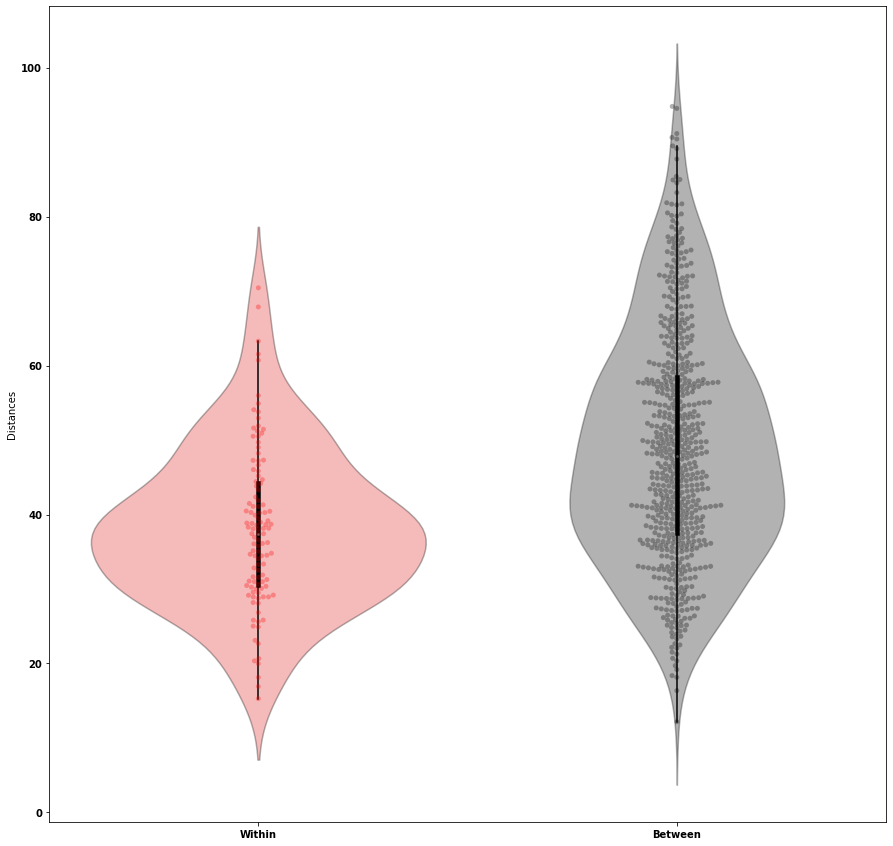

In [9]:
# plot our data:
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = [15, 15]

within_dists, outside_dists, _ = getGroupDistances(poa_comparison, groupings)
my_pal = ["r", "k"]
sns.swarmplot(data =  [within_dists, outside_dists], palette=my_pal)

ax = sns.violinplot(data =  [within_dists, outside_dists],  palette=my_pal)
plt.setp(ax.collections, alpha=0.3)
plt.ylabel('Distances')
_=ax.set_xticklabels(['Within','Between'])

Now generate a shuffle null distribution:

p-value:  0.0002


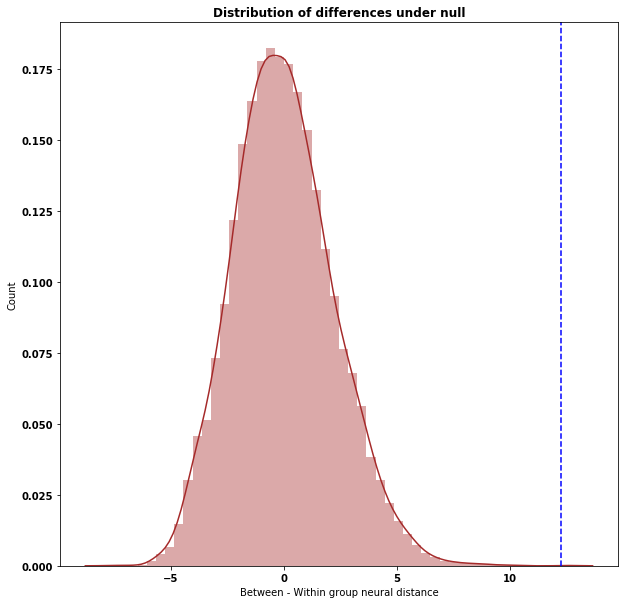

In [8]:
num_perms = 10000                                           # number of shuffles to run on our data
meandiff  = np.mean(outside_dists) - np.mean(within_dists)  # test statistic

nulldiffs = list() 

for i in range(num_perms):
    reordering  = np.random.permutation(poa_comparison.shape[0])
    poa_null  = poa_comparison[reordering, :][:, reordering]
   
    within_null, outside_null, _ = getGroupDistances(poa_null, groupings)
    nulldiffs.append(np.mean(outside_null) - np.mean(within_null))
    

matplotlib.rcParams['figure.figsize'] = [10, 10]

sns.distplot(nulldiffs, color='brown')
plt.axvline(meandiff, color = 'b', linestyle = '--')
plt.xlabel('Between - Within group neural distance')
plt.ylabel('Count')
plt.title('Distribution of differences under null', fontweight = 'bold')
    
print('p-value: ', (sum(nulldiffs > meandiff) + 1) / (len(nulldiffs)))